In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import math
import random

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
"""
ROOT_PATH = "./"
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


## Create a Torch.Dataset class for the training dataset

In [2]:
def get_rotation_matrix(inputs, device=DEVICE): 
    vectors = inputs[:, 1, :]
    matrices = torch.zeros((vectors.shape[0], 2, 2)).to(device).float()
    for i in range(vectors.shape[0]):
        matrices[i] = rotate_matrix(vectors[i]).to(device)
    return matrices

def rotate_matrix(v, device=DEVICE):
    """
    Rotates the vector into the (1, 1) direction
    """    
    a, b = v
    norm = torch.linalg.norm(v)
    if norm == 0:
        Q1 = torch.eye(2).to(device)
    else:
        Q1 = torch.tensor([[a, b], [-b, a]]).to(device) / torch.linalg.norm(v)
    Q2 = torch.tensor([[1, -1], [1, 1]]).to(device) / torch.sqrt(torch.tensor(2).to(device))
    
    return Q2.float() @ Q1.float()

In [3]:
# def normalize(A, Q, T):
#     return torch.matmul((A - T.unsqueeze(1)), Q.T)

def revert(A, Q, T):
    return torch.matmul(A, Q) + T.unsqueeze(1)

In [4]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=False, normalize=False):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.normalize = normalize
        self.split = split
        self.inputs, self.outputs = self.get_city_trajectories(city=city, split=split)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == 'train':       
            data = (self.inputs[idx], self.outputs[idx])
            return data     
        return self.inputs[idx]
    
    def get_city_trajectories(self, city="palo-alto", split="train", device=DEVICE):
        assert city in cities and split in splits

        # get input
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = torch.tensor(inputs).to(device).float()

        # store input starting positions and rotation matrix
        self.T0 = inputs[:, 0, :]

        # normalize inputs
        if self.normalize:     
            # translation
            inputs = inputs - self.T0.unsqueeze(1)
            
            # rotation
            self.Q0 = get_rotation_matrix(inputs)
            inputs = torch.matmul(inputs, self.Q0.transpose(1, 2))

        # get outputs
        outputs = None
        if split == "train":
            # get outputs
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = torch.tensor(outputs).to(device).float()
            
            # normalize outputs
            if self.normalize:      
                # translation
                outputs = outputs - self.T0.unsqueeze(1)
                    
                # rotation
                outputs = torch.matmul(outputs, self.Q0.transpose(1, 2))
        return inputs, outputs

In [5]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' #'test' #'train'
train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalize=True)

len(train_dataset)

11993

## Create a DataLoader class for training

In [6]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz, drop_last=True)
len(train_loader)

2998

## Sample a batch of data and visualize 

In [7]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    inp = inp.cpu().detach().numpy()
    out = out.cpu().detach().numpy()
    batch_sz, agent_sz = inp.shape[0], inp.shape[1]
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.2, wspace=.5)
    axs = axs.ravel()   
    for i in range(4):
        axs[i].xaxis.set_ticks([inp[i,0,0],
                                   inp[i,-1,0], out[i,-1,0]])
        axs[i].yaxis.set_ticks([inp[i,0,1],
                                   inp[i,-1,1], out[i,-1,1]])

        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

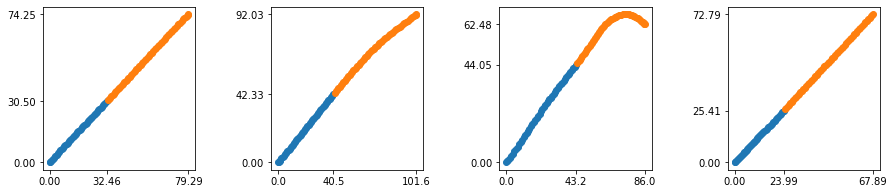

In [8]:
for i_batch, data in enumerate(train_loader):
    show_sample_batch(data)
    break

## Transformer

In [25]:
class TransAutoReg(nn.Module):
    def __init__(
        self,
        batch_size,
        model_dim,
        conv_depth=16,
        kernel_size=4,
        conv_padding=3,
        n_heads=8, 
        linear_dim=256, 
        dropout_rate=0.1, 
        encoder_layers=1,
        input_dim=2,
        regress_steps=4
    ):
        super(TransAutoReg, self).__init__()
        self.batch_size = batch_size
        self.model_dim = model_dim
        self.conv_depth = conv_depth
        self.kernel_size = kernel_size
        self.conv_padding = conv_padding
        self.n_heads = n_heads
        self.linear_dim = linear_dim
        self.dropout_rate = dropout_rate
        self.encoder_layers = encoder_layers
        self.input_dim = input_dim
        self.regress_steps = regress_steps
        self.input_length = 50
        self.output_length = 10
        
        # compute convolution output size
        size_1 = self.input_length + 2 * conv_padding - kernel_size + 1
        size_2 = size_1 + 2 * conv_padding - kernel_size + 1
        self.conv_outsize = (size_2 - kernel_size) // 2 + 1
        
        # input convolution
        self.input_convolution = nn.Sequential(
            nn.Conv1d(input_dim, conv_depth, kernel_size=kernel_size, padding=conv_padding),
            nn.LeakyReLU(),
            nn.Conv1d(conv_depth, conv_depth, kernel_size=kernel_size, padding=conv_padding),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=0)
        )  
        self.input_projection = nn.Linear(conv_depth, model_dim)
        
        # encoder
        encoder = nn.TransformerEncoderLayer(
            d_model=model_dim, 
            nhead=n_heads, 
            dim_feedforward=linear_dim, 
            dropout=dropout_rate, 
            batch_first=True,
            device=DEVICE
        )
        self.encoder = nn.TransformerEncoder(encoder, num_layers=encoder_layers, norm=None)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.conv_outsize * model_dim, linear_dim),
            nn.LeakyReLU(), 
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(), 
            nn.Linear(linear_dim, self.output_length * input_dim)
        )
    
    def get_angles(self, pos, i, D):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
        return pos * angle_rates

    def positional_encoding(self, D, position=110, dim=3, device=DEVICE):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                np.arange(D)[np.newaxis, :],
                                D)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        if dim == 3:
            pos_encoding = angle_rads[np.newaxis, ...]
        elif dim == 4:
            pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
        return torch.tensor(pos_encoding, device=device)
    
    def forward(self, inputs):
        input_pos = self.input_convolution(inputs.transpose(1, 2))
        input_pos = self.input_projection(input_pos.transpose(1, 2))
        input_pos += self.positional_encoding(self.model_dim)[:, :self.conv_outsize, :]
        memory = self.encoder(input_pos).reshape(self.batch_size, -1)
        out = self.decoder(memory)
        return out.reshape(self.batch_size, self.output_length, self.input_dim)

## Train the Transformer

In [34]:
def train(
    batch_size, 
    city, 
    model_dim,
    conv_depth,
    kernel_size,
    conv_padding,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    regress_steps,
    num_iters,
    learning_rate,
    factor,
    patience,
    device=DEVICE
):    
    # Create the training/validation set
    train_dataset = ArgoverseDataset(city=city, split='train', transform=False, normalize=True)
    train_sz = int(len(train_dataset) * 0.9)
    val_sz = len(train_dataset) - train_sz
    train_loader, val_loader = torch.utils.data.random_split(train_dataset, [train_sz, val_sz])
    train_loader = DataLoader(train_loader, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_loader, batch_size=batch_size, drop_last=True)
    
    # Initialize the model/optimizer/loss function
    model = TransAutoReg(
        batch_size=batch_size,
        model_dim=model_dim,
        conv_depth=conv_depth,
        kernel_size=kernel_size,
        conv_padding=conv_padding,
        n_heads=n_heads, 
        linear_dim=linear_dim, 
        dropout_rate=dropout_rate, 
        encoder_layers=encoder_layers,
        regress_steps=regress_steps
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    loss_function = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True) 
    
    # Print out how many parameters to train
    param_sizes = [p.numel() for p in model.parameters()]
    print(f"number of weight/biases matrices: {len(param_sizes)} "
          f"for a total of {np.sum(param_sizes)} parameters ")
    
    avg_train_loss, avg_val_loss = [], []
    best_val_score = float('inf')
    
    # Start training
    for epoch in tqdm(list(range(num_iters))):
        print(f'Epoch {epoch+1}')
        print('Training & Validating ', end='')
        
        train_loss, val_loss = [], []
        
        # Training set
        for batches, (X, y) in enumerate(train_loader):
            X = X.to(device).float()
            y = y.to(device).float()
            
            # Track progress
            if (batches + 1) % 20 == 0:
                print('-', end='')
            
            # Forward pass
            optimizer.zero_grad()
            out = model(X)
            
            # Backpropagation
            loss = loss_function(out, y[:, :10, :])
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            
        print()
        avg_train = np.mean(train_loss)
        avg_train_loss.append(avg_train)
        

        # Evaluate on val set
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device).float()
                y = y.to(device).float()
                
                out = predict(model, X)
                loss = loss_function(out, y)
                val_loss.append(loss.item())
                
            avg_val = np.mean(val_loss)
            avg_val_loss.append(avg_val)

        print(f'- Training Loss: {avg_train}')
        print(f'- Validation Loss: {avg_val}')
        print()
        
        scheduler.step(avg_val)
        
        # save better model
        if avg_val < best_val_score:
            best_val_score = avg_val
            torch.save(model, f'TF_Auto_Conv_{city}_0527.pt')
        
    return model, (avg_train_loss, avg_val_loss)

In [35]:
def predict(model, inputs):
    with torch.no_grad():
        total_steps = 60 // model.output_length

        # predict first roll
        step_pred = model(inputs)
#         print(inputs.shape, step_pred.shape)
        inputs = torch.cat((
            inputs,
            step_pred
        ), dim=1)

        for step in range(1, total_steps):
            # take chunk
            cur_inputs = inputs[:, step * model.output_length:, :].clone()

            # normalize
            T_t = cur_inputs[:, 0, :].clone()
            cur_inputs = cur_inputs - T_t.unsqueeze(1)

            Q_t = get_rotation_matrix(cur_inputs)
            cur_inputs = torch.matmul(cur_inputs, Q_t.transpose(1, 2))

            # autoregress
            step_pred = model(cur_inputs)

            # revert to original scale
            step_pred = torch.matmul(step_pred, Q_t) + T_t.unsqueeze(1)
            
            # add new predictions
            inputs = torch.cat((
                inputs,
                step_pred
            ), dim=1)

        return inputs[:, model.input_length:, :]

In [28]:
def plot_loss(start_from, city, split, losses):

    avg_train_loss, avg_val_loss = losses
    plt.plot(np.sqrt(avg_train_loss[start_from:]), label='train_loss')
    plt.plot(np.sqrt(avg_val_loss[start_from:]), label='validation_loss')
    plt.title(f'{city} RMSE {split} Loss vs. Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [29]:
def vis_results(city, split, batch_size, model, idx, device=DEVICE):
    train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalize=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    
    with torch.no_grad():
        for X, y in train_loader:
            X = X.to(device).float()
            y = y.to(device).float()

            out = model(X).reshape(batch_size, -1, 2)
            break
    
    X = X.cpu()
    y = y.cpu()
    out = out.cpu()
    
    Q = train_dataset.Q0[idx].cpu()
    T = train_dataset.T0[idx].cpu()
    X = X[idx] @ Q + T
    y = y[idx] @ Q + T
    out = out[idx] @ Q + T
    
    plt.scatter(X[:, 0], X[:, 1], label='seed')
    plt.scatter(y[:, 0], y[:, 1], label='ground truth')
    plt.scatter(out[:, 0], out[:, 1], label='prediction')
    plt.title(f'Random Sample From {city}_{split} Projectile Visualization')
    plt.legend()
    plt.show()

In [133]:
def vis_test(city, split, batch_sz, model, idx, norm_viz=True):
    '''
    This is the last batch, which is usually not complete and need to fill with 0s.
    Check if I convert the prediction back correctly or not
    '''
    
    # Create the dataset for testing
    test_dataset = ArgoverseDataset(city = city, split = split,
                                    transform=False, normalized=True)
        
    test_loader = DataLoader(test_dataset, batch_size=batch_sz)
    
    with torch.no_grad():
        for X in test_loader:
            if len(X) == batch_sz:
                continue
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0)).float()
            X = X.to(device).float()
            S = X.shape[1]
            mask = create_look_ahead_mask(S)

            output = model(X, mask)[0].reshape(batch_size, -1, 2)

            X = X.cpu()
            output = output.cpu()

            if norm_viz:
                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
            else:
                rotation =  test_dataset.rotate_matrix[-1].T
                X[idx] = X[idx] @ np.linalg.inv(rotation)
                X[idx] = X[idx] + test_dataset.start_pos[-1, : ]
                output[idx] = output[idx] @ np.linalg.inv(rotation)
                output[idx] = output[idx] + test_dataset.start_pos[-1, : ]

                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
    

In [142]:
def make_pred(test_loader, batch_sz, model):
    '''
    Remember to use test_dataset stats, NOT train_dataset
    '''
    count_row = 0
    out = []

    for X in test_loader:
        if len(X) != batch_sz:
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0))
            
#             a = test_dataset.rotate_matrix[-1].T
#             temp = X[20]@np.linalg.inv(a) + test_dataset.start_pos[-1]
#             plt.scatter(temp[:, 0], temp[:, 1], label='input')

        X = X.to(device).float()
    
        S = X.shape[1]
        mask = create_look_ahead_mask(S)

        pred = model(X, mask)[0].reshape(batch_size, -1, 2).cpu().detach().numpy()

        for i in range(batch_sz):
            if count_row >= len(test_dataset):
                break
                
#             if count_row == (len(test_dataset) - 1):
#                 plt.scatter(X[i, :, 0], X[i, :, 1], label='input')
#                 plt.scatter(pred[i, :, 0], pred[i, :, 1], label='pred')
#                 plt.legend()
#                 plt.show()

            rotation =  test_dataset.rotate_matrix[count_row].T
            pred[i] = pred[i] @ np.linalg.inv(rotation)
            pred[i] = pred[i] + test_dataset.start_pos[count_row, : ]

    #         print(pred[i, 0, :])
                
            out.append(pred[i])
            count_row += 1 
            
    #         print(count_row)
    #         print(pred[0, :5, :])

    out = np.array(out).reshape(len(test_dataset), -1)

    return out


### palo-alto

In [36]:
# Hyperparameter
batch_size = 32
city = 'palo-alto'
model_dim = 128
conv_depth = 32
kernel_size = 4
conv_padding = 3
n_heads = 8
linear_dim = 128 # [32, 128]
dropout_rate = 0.1 # [0, 0.5]
encoder_layers = 4
num_iters = 80 # [50, 100]
learning_rate = 0.002 # [0.001, 0.005]
factor = 0.5 # 0.1 ~ 0.99
patience = 3
regress_steps = 4

palo_net, palo_loss = train(
    batch_size, 
    city, 
    model_dim,
    conv_depth,
    kernel_size,
    conv_padding,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    regress_steps,
    num_iters,
    learning_rate,
    factor,
    patience,
    device=DEVICE
)

number of weight/biases matrices: 60 for a total of 868564 parameters 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1
Training & Validating ----------------
- Training Loss: 46.6364538648362
- Validation Loss: 111.65736100480363

Epoch 2
Training & Validating ----------------
- Training Loss: 5.944466229008638
- Validation Loss: 216.59598128860063

Epoch 3
Training & Validating ----------------
- Training Loss: 3.232091017222192
- Validation Loss: 141.08730274922138

Epoch 4
Training & Validating ----------------
- Training Loss: 5.285408096249804
- Validation Loss: 91.66031842618375

Epoch 5
Training & Validating ----------------
- Training Loss: 3.1711898610570666
- Validation Loss: 146.3517608642578

Epoch 6
Training & Validating ----------------
- Training Loss: 3.0199239533449846
- Validation Loss: 182.2935182726061

Epoch 7
Training & Validating ----------------
- Training Loss: 2.8647193342712582
- Validation Loss: 163.8831123145851

Epoch 8
Training & Validating ----------------
- Training Loss: 2.740385043426508
- Validation Loss: 106.99883641423406

Epoch     8: reducing learning rat